In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

x = np.arange(100, 110, 0.1)
start = datetime.now() - timedelta(days=7)

df = pd.DataFrame(
    {
        "time": [start + timedelta(days=n) for n in range(len(x))],
        "longitude": -48.6256,
        "latitude": -27.5717,
        "depth": 10,
        "u": np.sin(x),
        "v": np.cos(x),
        "station": "fake buoy",
    }
)


df.tail()

,time,longitude,latitude,depth,u,v,station
95,2021-09-06 13:36:57.985934,-48.6256,-27.5717,10,0.440129,-0.897934,fake buoy
96,2021-09-07 13:36:57.985934,-48.6256,-27.5717,10,0.348287,-0.937388,fake buoy
97,2021-09-08 13:36:57.985934,-48.6256,-27.5717,10,0.252964,-0.967476,fake buoy
98,2021-09-09 13:36:57.985934,-48.6256,-27.5717,10,0.155114,-0.987897,fake buoy
99,2021-09-10 13:36:57.985934,-48.6256,-27.5717,10,0.055714,-0.998447,fake buoy


(array([18779., 18793., 18809., 18823., 18840., 18854., 18871., 18885.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

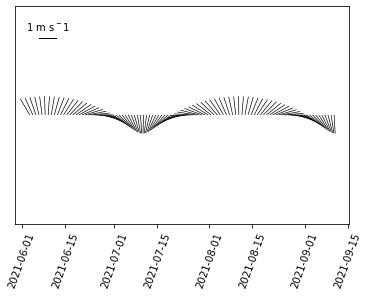

In [2]:
%matplotlib inline


import matplotlib.pyplot as plt
from oceans.plotting import stick_plot

q = stick_plot([t.to_pydatetime() for t in df["time"]], df["u"], df["v"])

ref = 1
qk = plt.quiverkey(
    q, 0.1, 0.85, ref, f"{ref} m s$^{-1}$", labelpos="N", coordinates="axes"
)

plt.xticks(rotation=70)

In [3]:
attributes = {
    "global": {
        "title": "Fake mooring",
        "summary": "Vector current meter ADCP @ 10 m",
        "institution": "Restaurant at the end of the universe",
        "cdm_timeseries_variables": "station",
        "subsetVariables": "depth",
    },
    "longitude": {"units": "degrees_east", "standard_name": "longitude",},
    "latitude": {"units": "degrees_north", "standard_name": "latitude",},
    "z": {"units": "m", "standard_name": "depth", "positive": "down",},
    "u": {"units": "m/s", "standard_name": "eastward_sea_water_velocity",},
    "v": {"units": "m/s", "standard_name": "northward_sea_water_velocity",},
    "station": {"cf_role": "timeseries_id"},
}

In [4]:
axes = {"t": "time", "x": "longitude", "y": "latitude", "z": "depth"}

In [5]:
from pocean.dsg.timeseries.om import OrthogonalMultidimensionalTimeseries
from pocean.utils import downcast_dataframe

df = downcast_dataframe(df)  # safely cast depth np.int64 to np.int32
dsg = OrthogonalMultidimensionalTimeseries.from_dataframe(
    df, output="fake_buoy.nc", attributes=attributes, axes=axes,
)

In [6]:
!ncdump -h fake_buoy.nc

netcdf fake_buoy {
dimensions:
	station = 1 ;
	time = 100 ;
variables:
	int crs ;
	double time(time) ;
		time:units = "seconds since 1990-01-01 00:00:00Z" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
	string station(station) ;
		station:cf_role = "timeseries_id" ;
		station:long_name = "station identifier" ;
	double latitude(station) ;
		latitude:axis = "Y" ;
		latitude:units = "degrees_north" ;
		latitude:standard_name = "latitude" ;
	double longitude(station) ;
		longitude:axis = "X" ;
		longitude:units = "degrees_east" ;
		longitude:standard_name = "longitude" ;
	int depth(station) ;
		depth:_FillValue = -9999 ;
		depth:axis = "Z" ;
	double u(station, time) ;
		u:_FillValue = -9999.9 ;
		u:units = "m/s" ;
		u:standard_name = "eastward_sea_water_velocity" ;
		u:coordinates = "time depth longitude latitude" ;
	double v(station, time) ;
		v:_FillValue = -9999.9 ;
		v:units = "m/s" ;
		v:standard_name = "northward_sea_water_velocity" ;
		v:coordinates = "time depth longitude la

In [7]:
dsg.getncattr("featureType")

'timeseries'

In [8]:
type(dsg)

pocean.dsg.timeseries.om.OrthogonalMultidimensionalTimeseries

In [9]:
[(v.standard_name) for v in dsg.data_vars()]

['eastward_sea_water_velocity', 'northward_sea_water_velocity']

In [10]:
dsg.axes("T")

[<class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     units: seconds since 1990-01-01 00:00:00Z
     standard_name: time
     axis: T
 unlimited dimensions: 
 current shape = (100,)
 filling on, default _FillValue of 9.969209968386869e+36 used]

In [11]:
dsg.axes("Z")

[<class 'netCDF4._netCDF4.Variable'>
 int32 depth(station)
     _FillValue: -9999
     axis: Z
 unlimited dimensions: 
 current shape = (1,)
 filling on]

In [12]:
dsg.vatts("station")

{'cf_role': 'timeseries_id', 'long_name': 'station identifier'}

In [13]:
dsg["station"][:]

array(['fake buoy'], dtype=object)

In [14]:
dsg.vatts("u")

{'_FillValue': -9999.9,
 'units': 'm/s',
 'standard_name': 'eastward_sea_water_velocity',
 'coordinates': 'time depth longitude latitude'}

In [15]:
dsg.to_dataframe().head()

,t,x,y,z,station,u,v
0,2021-06-03 13:36:57.985934,-48.6256,-27.5717,10,fake buoy,-0.506366,0.862319
1,2021-06-04 13:36:57.985934,-48.6256,-27.5717,10,fake buoy,-0.417748,0.908563
2,2021-06-05 13:36:57.985934,-48.6256,-27.5717,10,fake buoy,-0.324956,0.945729
3,2021-06-06 13:36:57.985934,-48.6256,-27.5717,10,fake buoy,-0.228917,0.973446
4,2021-06-07 13:36:57.985934,-48.6256,-27.5717,10,fake buoy,-0.130591,0.991436
